In [1]:
print "Monitoring URL: http://hadoop-lhr4-rm1.prod.booking.com:8088/proxy/" + spark.sparkContext.applicationId + '/stages'

Monitoring URL: http://hadoop-lhr4-rm1.prod.booking.com:8088/proxy/application_1513247814013_1126099/stages


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.sql.types import *

/opt/blue-python/2.7/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [49]:
h1b_data = pd.read_csv('h1b_kaggle.csv')

In [50]:
h1b_data_backup = h1b_data
h1b_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3002458 entries, 0 to 3002457
Data columns (total 11 columns):
Unnamed: 0            int64
CASE_STATUS           object
EMPLOYER_NAME         object
SOC_NAME              object
JOB_TITLE             object
FULL_TIME_POSITION    object
PREVAILING_WAGE       float64
YEAR                  float64
WORKSITE              object
lon                   float64
lat                   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 252.0+ MB


In [40]:
ser = pd.Series(['2016.0', '2017.0'],dtype='float64')
ser.astype(int) 

0    2016
1    2017
dtype: int64

In [53]:
h1b_data.head()

,Unnamed: 0,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat
0,1,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,BIOCHEMISTS AND BIOPHYSICISTS,POSTDOCTORAL RESEARCH FELLOW,N,36067.0,2016.0,"ANN ARBOR, MICHIGAN",-83.743038,42.280826
1,2,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,Y,242674.0,2016.0,"PLANO, TEXAS",-96.698886,33.019843
2,3,CERTIFIED-WITHDRAWN,"PORTS AMERICA GROUP, INC.",CHIEF EXECUTIVES,CHIEF PROCESS OFFICER,Y,193066.0,2016.0,"JERSEY CITY, NEW JERSEY",-74.077642,40.728158
3,4,CERTIFIED-WITHDRAWN,"GATES CORPORATION, A WHOLLY-OWNED SUBSIDIARY O...",CHIEF EXECUTIVES,"REGIONAL PRESIDEN, AMERICAS",Y,220314.0,2016.0,"DENVER, COLORADO",-104.990251,39.739236
4,5,WITHDRAWN,PEABODY INVESTMENTS CORP.,CHIEF EXECUTIVES,PRESIDENT MONGOLIA AND INDIA,Y,157518.4,2016.0,"ST. LOUIS, MISSOURI",-90.199404,38.627003


In [63]:
h1b_data.dropna(subset=['YEAR'],inplace=True)

In [64]:
h1b_data.YEAR = h1b_data.YEAR.astype(int)

In [65]:
h1b_data[h1b_data.WORKSITE.notnull()].head()

,Unnamed: 0,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat
0,1,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,BIOCHEMISTS AND BIOPHYSICISTS,POSTDOCTORAL RESEARCH FELLOW,N,36067.0,2016,"ANN ARBOR, MICHIGAN",-83.743038,42.280826
1,2,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,Y,242674.0,2016,"PLANO, TEXAS",-96.698886,33.019843
2,3,CERTIFIED-WITHDRAWN,"PORTS AMERICA GROUP, INC.",CHIEF EXECUTIVES,CHIEF PROCESS OFFICER,Y,193066.0,2016,"JERSEY CITY, NEW JERSEY",-74.077642,40.728158
3,4,CERTIFIED-WITHDRAWN,"GATES CORPORATION, A WHOLLY-OWNED SUBSIDIARY O...",CHIEF EXECUTIVES,"REGIONAL PRESIDEN, AMERICAS",Y,220314.0,2016,"DENVER, COLORADO",-104.990251,39.739236
4,5,WITHDRAWN,PEABODY INVESTMENTS CORP.,CHIEF EXECUTIVES,PRESIDENT MONGOLIA AND INDIA,Y,157518.4,2016,"ST. LOUIS, MISSOURI",-90.199404,38.627003


In [12]:
h1b_data['CASE_STATUS'].value_counts()

CERTIFIED                                             2615623
CERTIFIED-WITHDRAWN                                    202659
DENIED                                                  94346
WITHDRAWN                                               89799
PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED         15
REJECTED                                                    2
INVALIDATED                                                 1
Name: CASE_STATUS, dtype: int64

In [71]:
h1b_data['approve'] = 0
h1b_data.loc[h1b_data['CASE_STATUS'] == 'CERTIFIED', 'approve'] = 1

In [72]:
h1b_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3002445 entries, 0 to 3002444
Data columns (total 12 columns):
Unnamed: 0            int64
CASE_STATUS           object
EMPLOYER_NAME         object
SOC_NAME              object
JOB_TITLE             object
FULL_TIME_POSITION    object
PREVAILING_WAGE       float64
YEAR                  int64
WORKSITE              object
lon                   float64
lat                   float64
approve               int64
dtypes: float64(3), int64(3), object(6)
memory usage: 297.8+ MB


In [101]:
h1b_data_group = h1b_data.groupby('YEAR')

In [106]:
h1b_data_group['CASE_STATUS'].count()

YEAR
2011    358767
2012    415607
2013    442114
2014    519427
2015    618727
2016    647803
Name: CASE_STATUS, dtype: int64

In [110]:
total_count = pd.DataFrame(h1b_data_group['CASE_STATUS'].count()).reset_index()
total_count.rename(index=str, columns={"index": 'YEAR',"CASE_STATUS": 'total_count'},inplace=True)
total_count.info()
total_count.head()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 0 to 5
Data columns (total 2 columns):
YEAR           6 non-null int64
total_count    6 non-null int64
dtypes: int64(2)
memory usage: 144.0+ bytes


,YEAR,total_count
0,2011,358767
1,2012,415607
2,2013,442114
3,2014,519427
4,2015,618727


In [111]:
approve_count = pd.DataFrame(h1b_data_group['approve'].sum()).reset_index()
approve_count.rename(index=str, columns={"index": 'YEAR',"approve": 'approve_count'},inplace=True)
approve_count.info()
approve_count.head()


<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 0 to 5
Data columns (total 2 columns):
YEAR             6 non-null int64
approve_count    6 non-null int64
dtypes: int64(2)
memory usage: 144.0+ bytes


,YEAR,approve_count
0,2011,307936
1,2012,352668
2,2013,382951
3,2014,455144
4,2015,547278


In [114]:
combine = pd.merge(total_count,approve_count,on='YEAR',how='inner')
combine.head()

,YEAR,total_count,approve_count
0,2011,358767,307936
1,2012,415607,352668
2,2013,442114,382951
3,2014,519427,455144
4,2015,618727,547278


In [115]:
combine['approved_rate'] = combine['approve_count']/combine['total_count']

In [121]:
combine.approved_rate = combine.approved_rate.round(2)

In [122]:
combine.head()

,YEAR,total_count,approve_count,approved_rate
0,2011,358767,307936,0.86
1,2012,415607,352668,0.85
2,2013,442114,382951,0.87
3,2014,519427,455144,0.88
4,2015,618727,547278,0.88


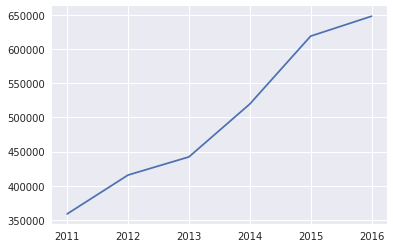

In [128]:
plt.plot(combine['YEAR'],combine['total_count'])

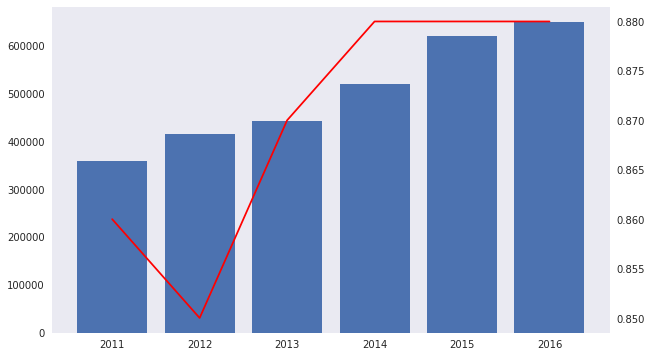

In [139]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.bar(combine['YEAR'],combine['total_count'])
ax2 = ax.twinx()
ax2.plot(combine['YEAR'],combine['approved_rate'],'red')
ax.grid(False)
ax2.grid(False)